# Implementing linear optics

In [3]:
import numpy as np
from scipy.linalg import block_diag

from discopy import monoidal
from discopy.monoidal import PRO
from discopy.tensor import Dim

In [4]:
@monoidal.Diagram.subclass
class OpticsDiagram(monoidal.Diagram):
    """
    Diagram with beam splitters and phases.
    """
    def __repr__(self):
        return super().__repr__().replace('Diagram', 'OpticsDiagram')
    
    @property
    def array(self):
        """ 
        The array corresponding to the diagram.
        Builds a block diagonal matrix for each layer and then multiplies them in sequence.
        """
        scan, array = self.dom, np.identity(len(self.dom))
        for box, off in zip(self.boxes, self.offsets):
            left, right = len(scan[:off]), len(scan[off + len(box.dom):])
            array = np.matmul(array, block_diag(np.identity(left), box.array, np.identity(right)))
        return array
    
class OpticsBox(OpticsDiagram, monoidal.Box):
    def __init__(self, name, dom, cod, data, **params):
        if not isinstance(dom, PRO):
            raise TypeError(messages.type_err(PRO, dom))
        if not isinstance(cod, PRO):
            raise TypeError(messages.type_err(PRO, cod))
        monoidal.Box.__init__(self, name, dom, cod, data=data, **params)
        OpticsDiagram.__init__(self, dom, cod, [self], [0], layers=self.layers)

    def __repr__(self):
        return super().__repr__().replace('Box', 'OpticsBox')
    
    @property
    def array(self):
        """ The array inside the box. """
        if isinstance(self, PhaseShift):
            return np.array(np.exp(self.data[0] * 1j))
        if isinstance(self, BeamSplitter):
            cos, sin = np.cos(self.data[0]), np.sin(self.data[0])
            return np.array([cos, -sin, sin, cos]).reshape((2, 2))
        return np.array(self.data).reshape(Dim(len(self.dom)) @ Dim(len(self.cod)) or (1, ))

class Id(monoidal.Id, OpticsDiagram):
    """ Identity tensor.Diagram """
    def __init__(self, dom=PRO()):
        monoidal.Id.__init__(self, dom)
        OpticsDiagram.__init__(self, dom, dom, [], [], layers=cat.Id(dom))
        
class PhaseShift(OpticsBox):
    def __init__(self, phase):
        super().__init__('Phase shift', PRO(1), PRO(1), [phase])  

        
class BeamSplitter(OpticsBox):
    def __init__(self, angle):
        super().__init__('Beam splitter', PRO(2), PRO(2), [angle])

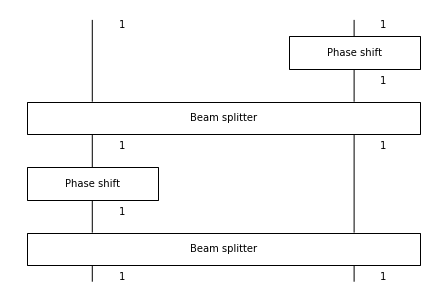

array([[ 0.27896958+0.32657455j, -0.87499017-0.22342167j],
       [ 0.66076206+0.61556359j,  0.42553092+0.05829583j]])

In [5]:
MZI = Id(PRO(1)) @ PhaseShift(0.5) >> BeamSplitter(0.6) >> PhaseShift(0.5) @ Id(PRO(1)) >> BeamSplitter(0.6)
MZI.draw()
MZI.array